<a href="https://colab.research.google.com/github/amutebe/msc_project/blob/main/model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# Define the path to your image dataset folder in Google Drive
dataset_path = '/content/drive/MyDrive/ESSEX/Msc_project/images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
'''
#Extract files from fibrosis.zip to fibrosis folder

import zipfile
import os

# Fibrosis images
zip_file_path = dataset_path+'/fibrosis.zip'
extract_path = dataset_path+'/fibrosis'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# No fibrosis images
zip_file_path = dataset_path+'/nofibrosis.zip'
extract_path = dataset_path+'/no_fibrosis'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
'''

"\n#Extract files from fibrosis.zip to fibrosis folder\n\nimport zipfile\nimport os\n\n# Fibrosis images\nzip_file_path = dataset_path+'/fibrosis.zip'\nextract_path = dataset_path+'/fibrosis'\n\n# Create the extraction directory if it doesn't exist\nif not os.path.exists(extract_path):\n    os.makedirs(extract_path)\n\n# Extract the files\nwith zipfile.ZipFile(zip_file_path, 'r') as zip_ref:\n    zip_ref.extractall(extract_path)\n\n# No fibrosis images\nzip_file_path = dataset_path+'/nofibrosis.zip'\nextract_path = dataset_path+'/no_fibrosis'\n\n# Create the extraction directory if it doesn't exist\nif not os.path.exists(extract_path):\n    os.makedirs(extract_path)\n\n# Extract the files\nwith zipfile.ZipFile(zip_file_path, 'r') as zip_ref:\n    zip_ref.extractall(extract_path)\n"

In [38]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import os
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score,precision_score


warnings.filterwarnings('ignore')

**IMPORTING AND PROCESSING IMAGES**


1.   Normalization of Image Data
2.   One-Hot Encoding of Labels
3.   Data Augmentation








In [39]:
#Seeding to ensure the experiment results are reproducible

seed = 412
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# Importing the images in subfolders named after classes
image_size = (32, 32)  # Initialising image size
num_classes = 2 # Defining the two image classes i.e Fibrosis and NoFibrosis
def load_images_from_folder(folder,image_size):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):  # Check if it's a directory
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                try:
                    img = cv2.imread(img_path)

                    # Get original image dimensions
                    height, width = img.shape[:2]

                    # Calculate aspect ratio
                    aspect_ratio = width / height

                    # Resize while maintaining aspect ratio
                    if aspect_ratio > 1:  # Width > Height
                        new_width = image_size[0]
                        new_height = int(new_width / aspect_ratio)
                    else:
                        new_height = image_size[1]
                        new_width = int(new_height * aspect_ratio)

                    img = cv2.resize(img, (new_width, new_height))

                    # Pad the image
                    delta_w = image_size[0] - new_width
                    delta_h = image_size[1] - new_height
                    top, bottom = delta_h//2, delta_h-(delta_h//2)
                    left, right = delta_w//2, delta_w-(delta_w//2)
                    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

                    img = img.astype('float32') / 255.0  # Normalize pixel values
                    images.append(img)
                    labels.append(label)  # Append class labels
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

    return np.array(images), np.array(labels)


# Loading and processing images from the directory
x, y = load_images_from_folder(dataset_path,image_size)


**Defining classes**

In [40]:
class_names = ['fibrosis','nofibrosis']



1.   Loading Images
3.   Splitng data into Training and Testing sets
2.   One-Hot encoding



In [41]:


# Convert labels to numerical categories
label_mapping = {label: i for i, label in enumerate(np.unique(y))}  # create mapping dict
y_numerical = np.array([label_mapping[label] for label in y])

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_numerical, test_size=0.2, random_state=42)

#One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2) # 2 classes for fibrosis and no fibrosis
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (160, 32, 32, 3)
y_train shape: (160, 2)
x_test shape: (40, 32, 32, 3)
y_test shape: (40, 2)


**Normalization of Image Data**


*   Subtracting the mean and dividing by the standard deviation of the training set, enhancing the model's training efficiency and effectiveness





In [42]:

# Convert pixel values data type to float32
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# Calculate the mean and standard deviation of the training images

mean = np.mean(x_train)                                                              #Compute the mean pixel value across the entire training dataset. This gives us a single mean value that represents the average brightness of all training images.
std  = np.std(x_train)                                                                  #Compute the standard deviation of the pixel values across the entire training dataset. This measures the amount of variation or dispersion from the mean.

# Normalize the data
# The tiny value 1e-7 is added to the denominator to prevent division by zero, which can occur if the standard deviation is extremely small.
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean) /(std+1e-7)

# normalization process is applied to the test and validation sets using the mean and standard deviation computed from the training set. This ensures that all datasets are normalized consistently.


**Data augmentation**

In [43]:

data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=20,

    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.2,

    # Shift images vertically by up to 12% of their height
    height_shift_range=0.2,

    # Randomly flip images horizontally
    horizontal_flip=True,


)

Define 2 images sizes for training

In [44]:
image_sizes = [(32,32),(128,128)]

In [45]:
# Define the optimizer (Adam)
optimizer = Adam(learning_rate=1e-3)
# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 10 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)



**CNN Model Architecture**

In [46]:
model = Sequential()

model.add(Conv2D(32,(1,1),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(244, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 244)                 │         499,956 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 244)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 592,926 (2.26 MB)

 Trainable params: 592,926 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

1. Fit the model on the training data, using the defined batch size and number of epochs
2. The validation data is used to evaluate the model's performance during training
3. The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
4. stopping training early if no improvement is observed

In [49]:
# Loop to ensure that the model is trained on the two image sizes for better performance
for size in image_sizes:
    # Load data with current image size
    x, y = load_images_from_folder(dataset_path, size)

    # Train the model
    history = model.fit(data_generator.flow(x_train, y_train, batch_size=16),
            epochs=30,
            validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping],
          verbose=2
           )

Epoch 1/30
10/10 - 4s - 401ms/step - accuracy: 0.5063 - loss: 0.7535 - val_accuracy: 0.5250 - val_loss: 0.6958 - learning_rate: 0.0010
Epoch 2/30
10/10 - 0s - 44ms/step - accuracy: 0.5750 - loss: 0.6992 - val_accuracy: 0.4750 - val_loss: 0.6980 - learning_rate: 0.0010
Epoch 3/30
10/10 - 1s - 61ms/step - accuracy: 0.5188 - loss: 0.6961 - val_accuracy: 0.4750 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 4/30
10/10 - 1s - 64ms/step - accuracy: 0.5063 - loss: 0.6925 - val_accuracy: 0.5750 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 5/30
10/10 - 1s - 60ms/step - accuracy: 0.5000 - loss: 0.6964 - val_accuracy: 0.5250 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 6/30
10/10 - 1s - 60ms/step - accuracy: 0.5312 - loss: 0.6943 - val_accuracy: 0.5250 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 7/30
10/10 - 1s - 63ms/step - accuracy: 0.5562 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 8/30
10/10 - 0s - 44ms/step - accuracy: 0.5125 - loss: 

**Results:**

In [50]:
# Make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print('Test Loss:    ', test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8208 - loss: 0.3971
Test accuracy: 0.824999988079071
Test Loss:     0.40001267194747925


In [51]:
# Save the model
model.save('model82_final.h5')

**Visualizing the Learning Curves**

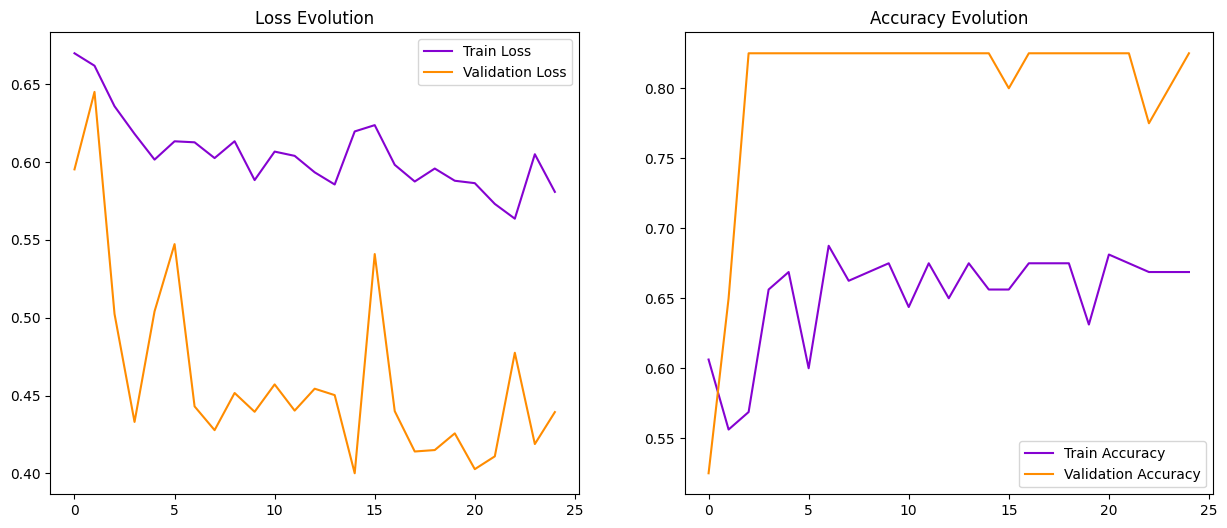

In [52]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

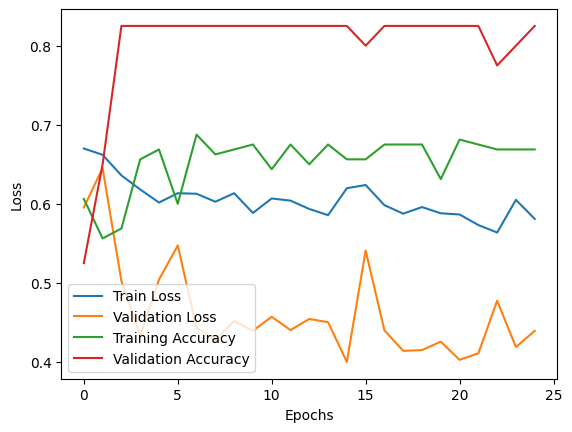

In [53]:
def plotloss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    plt.show()
plotloss(history)

**Generate a confusion matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


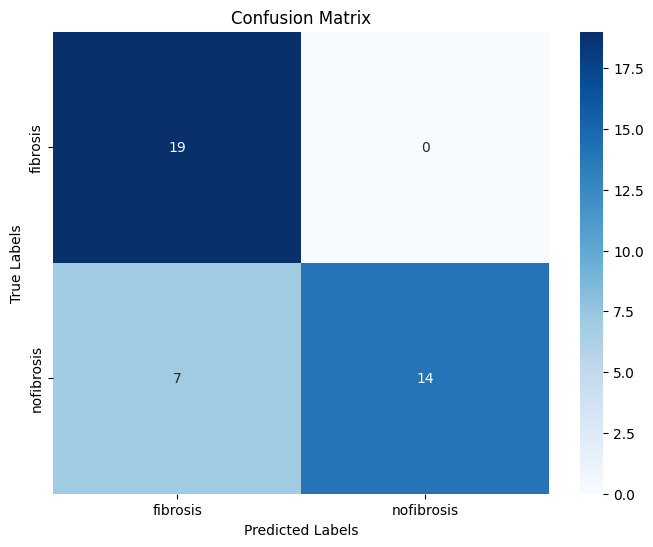

In [54]:
# Predict the classes for the test set
y_pred = np.argmax(model.predict(x_test), axis=1)

# Get the true classes from y_test
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**Generate a ROC and AUC**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


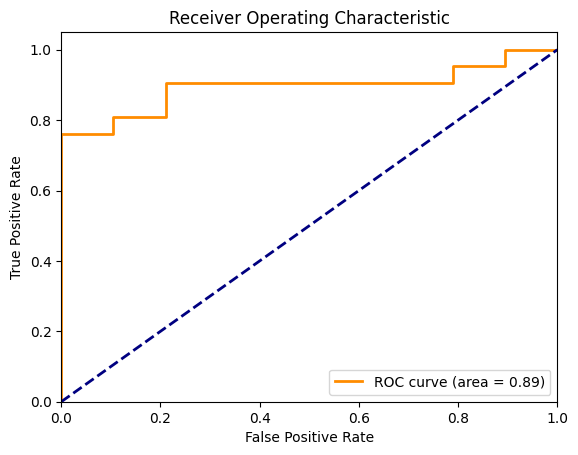

AUC: 0.8947368421052632


In [55]:
# Get predicted probabilities for the positive class
y_pred_prob = model.predict(x_test)[:, 1]  # Assuming binary classification

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_prob) # Assuming one-hot encoded labels
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")

**Precision**

In [56]:

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

Precision: 1.0


**Recall**

In [57]:
# Calculate Recall
recall = recall_score(y_true, y_pred, average='weighted') # Use weighted average for multi-class
print(f"Recall: {recall}")

Recall: 0.825


**F1 score**

In [58]:


# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted') # Use weighted average for multi-class
print(f"F1 Score: {f1}")

# ... (Rest of your existing code) ...

F1 Score: 0.8211111111111112


**Specificity**

In [59]:
# Calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp)

specificity = specificity_score(y_true, y_pred)
print(f"Specificity: {specificity}")

Specificity: 1.0
